# Iris MLP - multi-task - doctor model

Now studying the patient model.

## Setup

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import torch
from physics_mi.eval import plot_loss
from torch import nn
from tqdm.notebook import tqdm

In [3]:
class config:
    EPOCHS = 100
    LR = 1e-1

    N_SAMPLES = 30
    BOTTLE_DIM = 32

## Patient Model Data

In [4]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load the Iris dataset from sklearn
iris = datasets.load_iris()
X = iris.data
y = iris.target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Convert the data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_valid = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.int64)
y_valid = torch.tensor(y_test, dtype=torch.int64)

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

(torch.Size([120, 4]),
 torch.Size([120]),
 torch.Size([30, 4]),
 torch.Size([30]))

Now to create the stacked datasets:

In [5]:
from torch.utils.data import Dataset, DataLoader


class MultiIris(Dataset):
    def __init__(self, X, y):
        shuffled_indices = torch.randperm(len(X))
        self.X = torch.cat((X, X[shuffled_indices]), dim=1)
        self.y = torch.stack((y, y[shuffled_indices])).T

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

## Embedding network

Just going to look at this single hidden layer. I think there should be three target components for each independent task and I'd _hope_ to see similar functional embeddings between them.

This node dataframe contains all the nodes across two different layers.

In [6]:
from physics_mi.analysis import capture_intermediate_outputs
from physics_mi.graph import generate_graph
from physics_mi.analysis import plot_similarity_matrix, get_sims

In [7]:
from iris_basics import model as iris_model, Net

iris_model.load_state_dict(torch.load("models/iris-mlp.pth"))  # load the entire model weights
iris_layer = iris_model.layers[1]  # just the layer we're going to examine
_ = iris_layer.requires_grad_(True)

In [8]:
iris_dset = MultiIris(X_train, y_train)
iris_dl = DataLoader(iris_dset, batch_size=len(iris_dset), shuffle=True)
xb = next(iter(iris_dl))[0]
ios = capture_intermediate_outputs(iris_model, xb)
ios["input"] = xb

In [9]:
class ScaffoldNet(Net):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.requires_grad_(False)

    def forward(self, lidx, linputs):
        sub_net = self.layers[1:][lidx : lidx + 1]
        out = sub_net(linputs)
        return out


class ScaffoldLayer(nn.Module):
    def __init__(self, layer, components) -> None:
        super().__init__()
        self.layer = layer
        self.components = components

    def forward(self, x):
        out = self.layer(x)
        out = torch.einsum("bi,ji->bj", out, self.components)
        return out


scaffold_model = ScaffoldNet(input_dim=8, hidden_dim=64, output_dim=2 * y_train.unique().shape[0])
scaffold_model.load_state_dict(iris_model.state_dict())

<All keys matched successfully>

In [10]:
layer_keys = [
    "layers.0.act",
    "layers.1.act",
    "layers.2.linear.bias",
]  # these are where from we would like to extract the components

In [11]:
ndf, edf = generate_graph(ios, layer_keys, scaffold_model)

  0%|          | 0/2 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [12]:
node_df = ndf.loc[ndf["layer"].isin(["layers.1.act", "layers.0.act"])]
node_df

,layer,comp,norm
node,,,
6,layers.1.act,"[tensor(0.0014), tensor(-0.0007), tensor(0.001...",0.011708
7,layers.1.act,"[tensor(0.0019), tensor(-0.0010), tensor(-0.00...",0.011567
8,layers.1.act,"[tensor(-0.0029), tensor(0.0014), tensor(-0.00...",0.013751
9,layers.1.act,"[tensor(0.0005), tensor(-0.0020), tensor(0.001...",0.011946
10,layers.1.act,"[tensor(0.0007), tensor(0.0006), tensor(0.0010...",0.011326
...,...,...,...
577,layers.0.act,"[tensor(0.0022), tensor(-0.0006), tensor(-0.00...",0.013320
578,layers.0.act,"[tensor(0.0012), tensor(-0.0009), tensor(-0.00...",0.010034
579,layers.0.act,"[tensor(0.0018), tensor(-0.0007), tensor(-0.00...",0.012722


This edge dataframe contains the connectivity information between the components across this layer.

In [13]:
edge_df = edf.loc[edf["target"].isin(node_df.loc[node_df.layer == "layers.1.act"].index)]
edge_df

,source,target,weight
6,12,6,0.013634
7,13,6,0.010585
8,14,6,0.010007
9,15,6,0.010638
10,16,6,0.011752
...,...,...,...
571,577,11,0.013320
572,578,11,0.010034
573,579,11,0.012722
574,580,11,0.012382


I think this is enough info to get going with the complicated task of arranging the data to train our embedder model 😵‍💫

We'll essentially need to:
- load up our scaffold model and then slice it to this layer of interest (`layers.0.act` $\rightarrow$ `layers.1.act`)
- Then for each training sample we'd pick one of the six components in `layers.1.act`
- pick $n$ training examples to sample the gradient field
- forward pass
- backward pass
- extract gradients
- mask gradients

Then we can use these for our cloze task to train the embedder model.

There are only 6 computational units in this case so I wonder if there'll be enough diversity to train the model well. Then again, we can sample the gradient field differently each time so maybe that would balance out. Whereas before we were only sparse sampling the computational unit space and a dense sampling the gradient field space, here we're dense sampling the computational unit space and sparse sampling the gradient field space. We'll see how that plays out 🤷 

In [14]:
components = torch.stack(node_df.loc[node_df.layer == "layers.1.act", "comp"].tolist())
components = components / components.norm(dim=1).unsqueeze(1)
components.requires_grad_(True)
components.shape

torch.Size([6, 64])

In [15]:
scaffold_layer = ScaffoldLayer(iris_layer, components)

### Data

In [16]:
from physics_mi.utils import unique


class GradientDataset(Dataset):
    def __init__(
        self,
        patient_model: Net,
        scaffold_layer: ScaffoldLayer,
        X: torch.Tensor,
        y: torch.Tensor,
        mask: bool = True,
        n_samples: int = 50,
    ) -> None:
        self.mask = mask
        self.patient_model = patient_model
        self.scaffold_layer = scaffold_layer
        self.scaffold_layer.eval()
        for param in self.scaffold_layer.parameters():
            param.requires_grad = False
        self.n_samples = n_samples
        self.X = X
        self.y = y

    def __len__(self) -> int:
        return len(self.X)

    def mask_grads(self, input_grads):
        """
        Masks a portion of the input gradients.

        Args:
            input_grads (torch.Tensor): The input gradients to be masked.

        Returns:
            torch.Tensor: The masked gradients, where a portion of the gradients are set to -1.

        """
        uq_grads, _, _, index = unique(input_grads)
        uq_grads = uq_grads[torch.argsort(index)]
        n_grads = len(uq_grads)
        window_size = int(n_grads // 3)
        window_start = np.random.randint(0, n_grads - window_size)
        mask_grads = uq_grads[window_start : window_start + window_size]
        mask = torch.isin(input_grads, mask_grads)
        masked = input_grads.clone()
        masked[mask] = -1
        return masked

    def __getitem__(self, i, study_comp=None):
        # Get the input to the layer
        iris_dset = MultiIris(self.X, self.y)
        iris_dl = DataLoader(iris_dset, batch_size=len(iris_dset), shuffle=True)
        xb, _ = next(iter(iris_dl))
        linput = capture_intermediate_outputs(self.patient_model, xb)["layers.0.act"].clone().detach()
        linput = linput[torch.multinomial(torch.ones(linput.size(0)), self.n_samples)]
        linput.requires_grad = True

        # Get the component activations from the output of the layer
        out = self.scaffold_layer(linput)

        # Get the layer input gradients for a randomly selected component (computational unit)
        if study_comp is None:
            study_comp = torch.randint(0, out.shape[1], (1,))
        out = out[:, study_comp]
        loss = out.mean()
        loss.backward()
        input_grads = linput.grad.clone().detach()

        # Mask the gradients
        if self.mask:
            x = self.mask_grads(input_grads)
        else:
            x = input_grads
        x = torch.stack([linput, x], dim=2)  # need to stack with inputs so the model knows where to look
        y = input_grads.view(-1)  # TODO potentially mask out the y values too in order to focus the loss
        x = x.view(-1)
        x = x.detach()
        y = y.detach()
        return x, y

In [17]:
g_train_dset = GradientDataset(iris_model, scaffold_layer, mask=True, n_samples=config.N_SAMPLES, X=X_train, y=y_train)
g_valid_dset = GradientDataset(iris_model, scaffold_layer, mask=True, n_samples=config.N_SAMPLES, X=X_valid, y=y_valid)
g_eval_dset = GradientDataset(iris_model, scaffold_layer, mask=False, n_samples=config.N_SAMPLES, X=X_valid, y=y_valid)

g_train_dl = DataLoader(g_train_dset, batch_size=len(g_train_dset), shuffle=True)
g_valid_dl = DataLoader(g_valid_dset, batch_size=len(g_valid_dset), shuffle=False)
g_eval_dl = DataLoader(g_eval_dset, batch_size=len(g_eval_dset), shuffle=False)

xb, yb = next(iter(g_train_dl))
xb.shape, yb.shape

(torch.Size([120, 3840]), torch.Size([120, 1920]))

### Model

In [18]:
from physics_mi.net import LinearLayer


class GradNet(nn.Module):
    def __init__(
        self, input_dim=4, hidden_dim=16, bottle_dim=4, output_dim=2, embedding_mode=False, *args, **kwargs
    ) -> None:
        super().__init__(*args, **kwargs)
        self.down_layers = nn.Sequential(
            LinearLayer(input_dim, hidden_dim, use_act=True),
            LinearLayer(hidden_dim, bottle_dim, use_act=True),
        )
        self.up_layers = LinearLayer(bottle_dim, output_dim, use_act=True)
        self.output_layer = LinearLayer(output_dim, output_dim, use_act=False)
        self.embedding_mode = embedding_mode

    def forward(self, x):
        out = self.down_layers(x)
        if self.embedding_mode:
            return out
        out = self.up_layers(out)
        out = out + x.view(len(x), -1, 2)[:, :, 1]  # residual connection
        return self.output_layer(out)

### Train

In [19]:
from torch.optim.lr_scheduler import OneCycleLR
from torch.optim import Adam


gmodel = GradNet(input_dim=xb.shape[1], hidden_dim=128, bottle_dim=config.BOTTLE_DIM, output_dim=yb.shape[1])
optimiser = Adam(gmodel.parameters(), lr=1e-3)
loss_func = nn.MSELoss()
total_steps = len(g_train_dl) * config.EPOCHS
scheduler = OneCycleLR(optimiser, max_lr=1e-3, total_steps=total_steps)

log = []

for epoch in tqdm(range(config.EPOCHS)):
    log_sample = {}

    gmodel.train()
    for xb, yb in g_train_dl:
        y_hat = gmodel(xb)
        loss = loss_func(y_hat, yb)
        loss.backward()
        optimiser.step()
        optimiser.zero_grad()
        scheduler.step()

    gmodel.eval()
    valid_loss = 0
    for xb, yb in g_valid_dl:
        with torch.no_grad():
            y_hat = gmodel(xb)
            # mask = xb.view(len(xb), -1, 2)[:, :, 1] == -1
            # valid_loss += nn.MSELoss()(y_hat[mask], yb[mask])
            valid_loss += nn.MSELoss()(y_hat, yb)

    log_sample["valid_loss"] = float(valid_loss / len(g_valid_dl))
    log_sample["train_loss"] = float(loss)
    log.append(log_sample)

log = pd.DataFrame(log)

  0%|          | 0/200 [00:00<?, ?it/s]

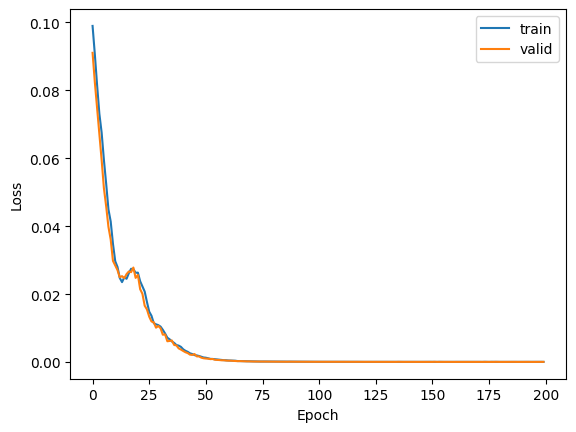

In [20]:
plot_loss(log["train_loss"], log["valid_loss"])

In [21]:
def get_preds(model, valid_dl):
    model.eval()

    X = []
    y_preds = []
    y_targs = []

    for xb, yb in valid_dl:
        with torch.inference_mode():
            out = model(xb)
        X.append(xb.view(len(xb), -1, 2)[:, :, 1])
        y_preds.append(out)
        y_targs.append(yb)

    X = torch.cat(X).numpy()
    y_preds = torch.cat(y_preds).numpy()
    y_targs = torch.cat(y_targs).numpy()

    return y_preds, y_targs, X

In [22]:
torch.save(gmodel.state_dict(), "models/iris-gradnet.pth")

### Examine embeddings

In [23]:
embed_model = GradNet(
    input_dim=xb.shape[1], hidden_dim=128, bottle_dim=config.BOTTLE_DIM, output_dim=yb.shape[1], embedding_mode=True
)
embed_model.load_state_dict(gmodel.state_dict())

<All keys matched successfully>

In [24]:
inputs = []
for study_comp in range(len(components)):
    comp_inputs = torch.stack([g_eval_dset[i, study_comp][0] for i in range(len(g_eval_dset))])
    inputs.append(comp_inputs)
inputs = torch.stack(inputs).detach()

with torch.inference_mode():
    embeds = embed_model(inputs.view(-1, xb.shape[1]))

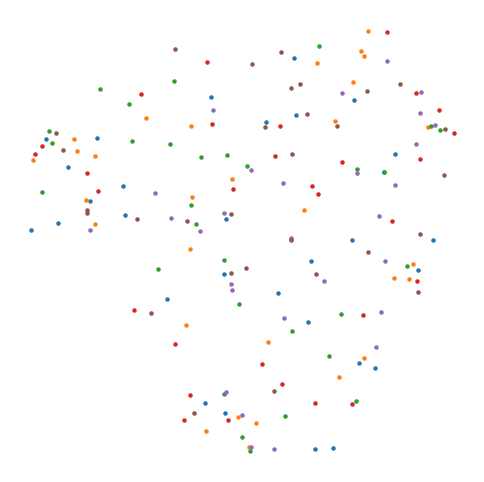

In [25]:
import pacmap
from matplotlib import pyplot as plt

# Initializing the PaCMAP instance
embedding = pacmap.PaCMAP(n_components=2, n_neighbors=None, MN_ratio=0.5, FP_ratio=2.0)

# Fitting the data
X_transformed = embedding.fit_transform(embeds, init="pca")
X_transformed = X_transformed.reshape(len(components), -1, 2)

# Visualizing the embedding
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
for i in range(len(components)):
    ax.scatter(X_transformed[i, :, 0], X_transformed[i, :, 1], s=5)

_ = ax.axis("off")

In [28]:
embeds.shape

torch.Size([180, 32])

In [31]:
sims = torch.einsum("ij,kj->ik", embeds, embeds)

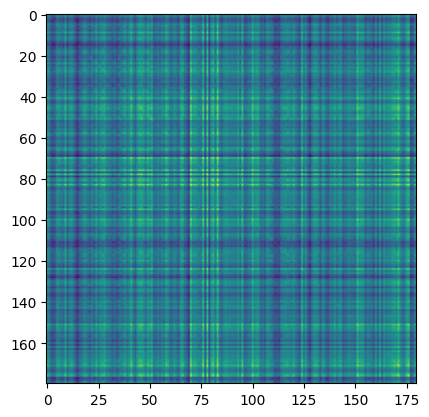

In [33]:
plt.imshow(sims.detach().numpy(), cmap="viridis");

Not sure if I'm getting anywhere here. There are too many variables to debug properly. I'm not sure if:
- my core approach is flawed
- I haven't trained my embedding model very well
- my analysis isn't correct
- there's some bug somewhere (entirely likely)

Part of the issue is that I'm _not sure what I'm expecting to find_. In this situation, it's probably the case that I've reached too far and I should scale back my current ambitions so that this experiment isn't so much of a leap. That could involve:
- taking `008-net-embed/05-bottleneck-satic-grid.ipynb` and scaling up the dimensionality of the input space to be more akin to what we have here. If I get get an embedding model working well _there_ I might then be able to apply it with more confidence here.
- one potential issue is that the functions I'm trying to model are too similar to each other, I suppose I can study that aspect in the experiment I just mentioned. 